<a href="https://colab.research.google.com/github/atharva-ketkar1/DemographicPredictor/blob/main/retry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import keras.backend as K
from tqdm import tqdm
from itertools import product
from functools import partial
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.losses import mean_absolute_error, binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q '/content/drive/MyDrive/Demographic Predictor Files/UTKFace.zip';

In [3]:
#path = '/content/drive/MyDrive/Demographic Predictor Files/UTKFace'
path = 'UTKFace'
age_labels = []
gender_labels = []
race_labels = []
image_paths = []

images = os.listdir(path)
#random.shuffle(images)

for image in images:
  split = image.split("_")
  if len(split) < 4:
    continue
  image_path = os.path.join(path,image)
  age_label = int(split[0])
  gender_label = int(split[1])
  race_label = int(split[2])

  image_paths.append(image_path)
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  race_labels.append(race_label)

In [4]:
df = pd.DataFrame()
df['image_paths'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels

# Data Preprocessing

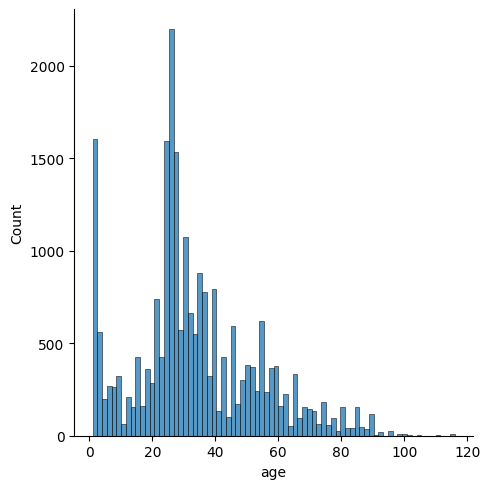

In [5]:
sns.displot(df['age'])

In [6]:
df['age'].value_counts()

age
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
91        2
101       2
103       1
111       1
Name: count, Length: 104, dtype: int64

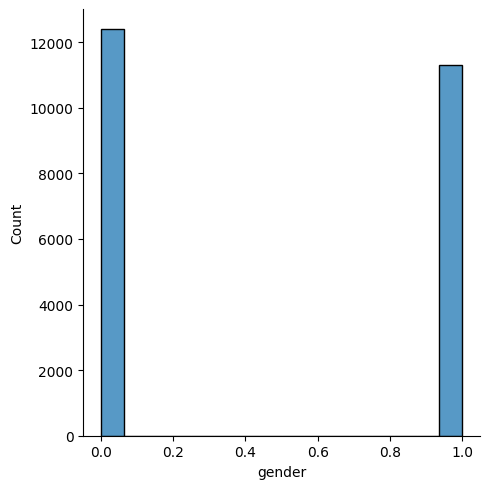

In [7]:
#[gender] is either 0 (male) or 1 (female)
sns.displot(df['gender'])

In [8]:
df['gender'].value_counts()

gender
0    12391
1    11314
Name: count, dtype: int64

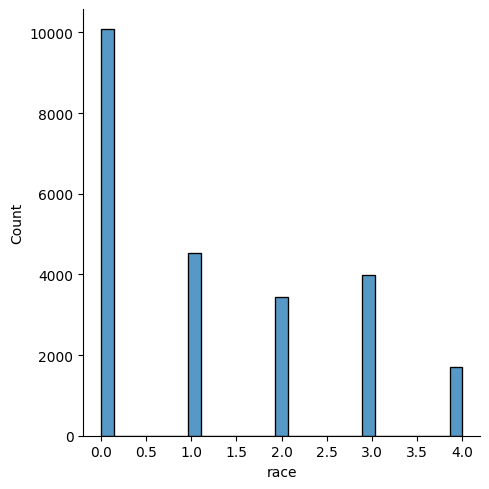

In [9]:
#[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
sns.displot(df['race'])

In [10]:
df['race'].value_counts()

race
0    10078
1     4526
3     3975
2     3434
4     1692
Name: count, dtype: int64

##### Age is pretty right skewed, gender has more women than men, and race is very imbalanced. Will have to take this into account when I am going to train

# Feature Extraction

In [11]:
image_size = (200,200)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(200,200, 3))

def extract_features(img_path, model, target_size=image_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

# Takes very long to run and uses up too many Colab credits, so I am going to run it locally and upload it to my Drive

# features = []
# for img_path in tqdm(df['image_paths']):
#     features.append(extract_features(img_path, vgg16))
# features = np.array(features)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
features = np.load('/content/drive/MyDrive/Demographic Predictor Files/models/features.npy')

smote = SMOTE()

# Have to filter out the classes in age that don't have enough samples because SMOTE doesn't like that
filtered_df = df.groupby('age').filter(lambda x: len(x) >= 6)

filtered_features = features[filtered_df.index]
filtered_age_labels = filtered_df['age']

features_resampled_age, age_resampled = smote.fit_resample(filtered_features, filtered_age_labels)

features_resampled_gender, gender_resampled = smote.fit_resample(features, df['gender'])

features_resampled_race, race_resampled = smote.fit_resample(features, df['race'])


In [ ]:
# Convert these to np arrays for training
y_age_resampled = np.array(age_resampled)
y_gender_resampled = np.array(gender_resampled)
y_race_resampled = tf.keras.utils.to_categorical(np.array(race_resampled), num_classes=5)

# Visualizing SMOTE Resampled Data

In [ ]:
age_resampled.value_counts()

In [ ]:
sns.displot(age_resampled)

In [ ]:
gender_resampled.value_counts()

In [ ]:
sns.displot(gender_resampled)

In [ ]:
race_resampled.value_counts()

In [ ]:
sns.displot(race_resampled)

##### There is now an equal number of samples in every class for age,gender,and race.

# Training and Fitting the Model

In [ ]:
input_shape = Input(shape=(200, 200, 3))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_shape)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# Fully connected layers for age prediction
dense_age = Dense(256, activation='relu')(flatten)
dropout_age = Dropout(0.3)(dense_age)
output_age = Dense(1, activation='linear', name='age_output')(dropout_age)

# Fully connected layers for gender prediction
dense_gender = Dense(256, activation='relu')(flatten)
dropout_gender = Dropout(0.3)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender)

# Fully connected layers for race prediction
dense_race = Dense(256, activation='relu')(flatten)
dropout_race = Dropout(0.3)(dense_race)
output_race = Dense(5, activation='softmax', name='race_output')(dropout_race)

model = Model(inputs=input_shape, outputs=[output_age, output_gender, output_race])

model.compile(optimizer='adam',
              loss={'age_output': 'mae',
                    'gender_output': 'binary_crossentropy',
                    'race_output': 'categorical_crossentropy'},
              metrics={'age_output': 'mae',
                       'gender_output': 'accuracy',
                       'race_output': 'accuracy'})

In [ ]:
history = model.fit(x=X,
                    y={'age_output': y_age_resampled,
                       'gender_output': y_gender_resampled,
                       'race_output': y_race_resampled},
                    validation_split = 0.2,
                    batch_size=32, epochs=50)

In [ ]:
model_save_path = '/content/drive/MyDrive/Demographic Predictor Files/models/retrymodel.keras'
model_save_path2 = '/content/drive/MyDrive/Demographic Predictor Files/models/retrymodel.h5'

# Save the model
model.save(model_save_path)
model.save(model_save_path2)

# Testing the Model on Sample Images

In [ ]:
genders = {
    1: 'Female',
    0: 'Male'
}

race_labels = ['White', 'Black', 'Asian', 'Indian', 'Hispanic, Latino, Middle Eastern, etc']

def load_and_predict_demographics(image_path, model):
    img = load_img(image_path)
    img = img.resize((200, 200), Image.LANCZOS)
    img = np.array(img)
    img = img.reshape(1, 200, 200, 3)
    img = img / 255.0

    pred = model.predict(img)

    predicted_age = round(pred[0][0][0])
    predicted_gender = genders[round(pred[1][0][0])]
    predicted_race = np.argmax(pred[2][0][0])
    predicted_race_label = race_labels[predicted_race]

    return predicted_age, predicted_gender, predicted_race_label

def predict_and_display_demographics(image_path, model):
    predicted_age, predicted_gender, predicted_race_label = load_and_predict_demographics(image_path, model)

    plt.title(f'Predicted Age: {predicted_age}, Predicted Gender: {predicted_gender}, Predicted Race: {predicted_race_label}')
    plt.axis('off')
    plt.imshow(np.array(load_img(image_path)))
    plt.show()


In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/1.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/2.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/4.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/trump.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/jayz.jpeg'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/kodak.jpeg'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/meeks.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/7_1_1_20170109194708063.jpg.chip.jpg'

predict_and_display_demographics(img_to_test, model)